In [1]:
%pylab inline
import sys
sys.path.insert(0, '..')

Populating the interactive namespace from numpy and matplotlib


## Loading data

In [2]:
import numpy as np

In [3]:
d = np.load('flow_cylinder.npy')

In [4]:
d.shape

(151, 384, 199)

In [5]:
384*199

76416

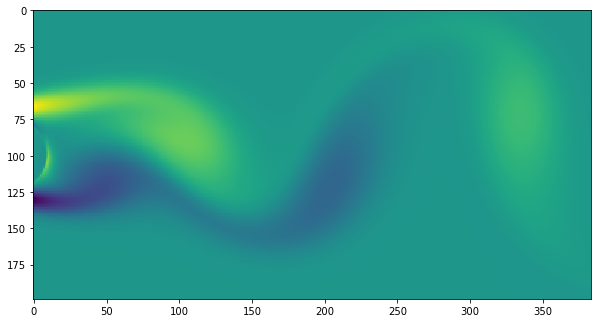

In [6]:
figure(figsize=(10,20))
imshow(d[1].T)

## Network definition

In [7]:
import tensorflow as tf
from fluidflow.nets import  dense_encoder
from fluidflow.bijections import Orthogonal
from fluidflow.optimizers import RMSpropNatGrad


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [8]:
def dense_decoder(code,
                  output_size=76416,
                  output_channels=1,
                  activation=tf.nn.leaky_relu,
                  is_training=True, reuse=tf.AUTO_REUSE, scope='decoder'):
    """
    Decoder using a dense neural network
    """
    with tf.variable_scope(scope, [code], reuse=reuse) as sc:
        net = tf.layers.dense(code, 200, activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 200, activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, output_size, activation=None)
        return net

In [9]:
hidden_size = 10
tf.reset_default_graph()

x = tf.placeholder(shape=(None, 76416), dtype=tf.float32)
x2 = tf.placeholder(shape=(None, 76416), dtype=tf.float32)

bijection = Orthogonal(hidden_size, hidden_size)
eigv = tf.get_variable(name='eigen_values',
                       initializer=tf.ones(hidden_size, dtype=tf.float32))

# Encode the data to  lower dimensionality space
z1 = dense_encoder(x, latent_size=hidden_size)

# Apply the orthogonal transform
h = bijection.forward(z1)
# Apply a vector of eigen values
h= h * eigv
# Apply the transpose of the orhogonal transform
z2 = bijection.inverse(h)

xrec = dense_decoder(z1, output_size=76416)
xpred = dense_decoder(z2, output_size=76416)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.


In [10]:
loss = tf.reduce_mean( tf.nn.l2_loss(xrec - x) + tf.nn.l2_loss(xpred - x2))

In [11]:
global_step = tf.train.get_or_create_global_step()
lr = tf.placeholder_with_default(0.001, shape=[])
optimizer = RMSpropNatGrad(learning_rate=lr,
                           global_step=global_step)

opt_op = optimizer.minimize(loss)

Appling an orthogonality preserving step to Orthogonal//orthogonal_stiefel/A:0
Appling standard rmsprop to eigen_values:0
Appling standard rmsprop to encoder/dense/kernel:0
Appling standard rmsprop to encoder/dense/bias:0
Appling standard rmsprop to encoder/dense_1/kernel:0
Appling standard rmsprop to encoder/dense_1/bias:0
Appling standard rmsprop to encoder/dense_2/kernel:0
Appling standard rmsprop to encoder/dense_2/bias:0
Appling standard rmsprop to decoder/dense/kernel:0
Appling standard rmsprop to decoder/dense/bias:0
Appling standard rmsprop to decoder/dense_1/kernel:0
Appling standard rmsprop to decoder/dense_1/bias:0
Appling standard rmsprop to decoder/dense_2/kernel:0
Appling standard rmsprop to decoder/dense_2/bias:0


## Training

In [12]:
# just got to do some training now
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [13]:
losses = []
dt = d.reshape([151, -1])
dt1 = dt[:-1]
dt2 = dt[1:]

In [46]:
for i in range(10):
    _, l = sess.run([opt_op, loss], feed_dict={x:dt1, x2:dt2, lr:0.000002} )
    losses.append(l)

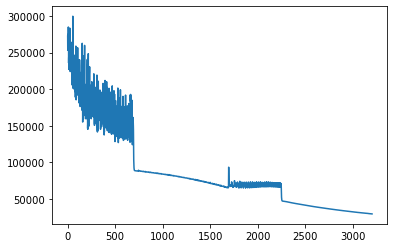

In [47]:
plot(losses)

In [43]:
xin, xout, xp = sess.run([x, xrec, xpred], feed_dict={x:dt1, x2:dt2, lr:0.0001})

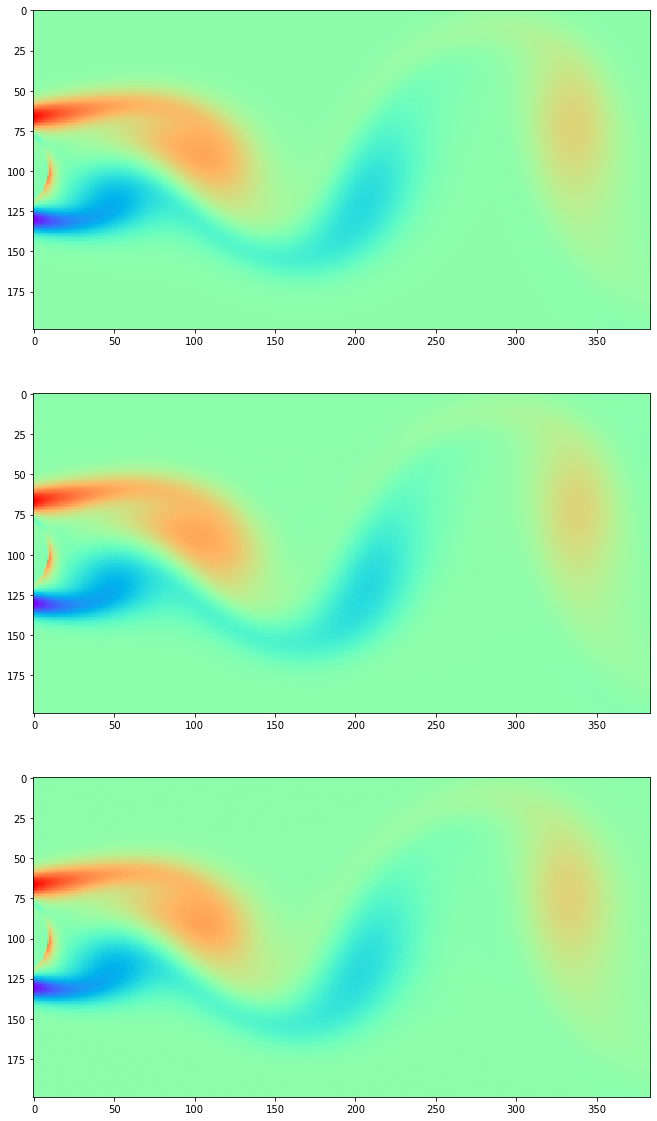

In [44]:
figure(figsize=(30,20))
subplot(311)
imshow(xin[1].reshape((384,199)).T,cmap='rainbow')
subplot(312)
imshow(xout[1].reshape((384,199)).T,cmap='rainbow')
subplot(313)
imshow(xp[0].reshape((384,199)).T,cmap='rainbow')

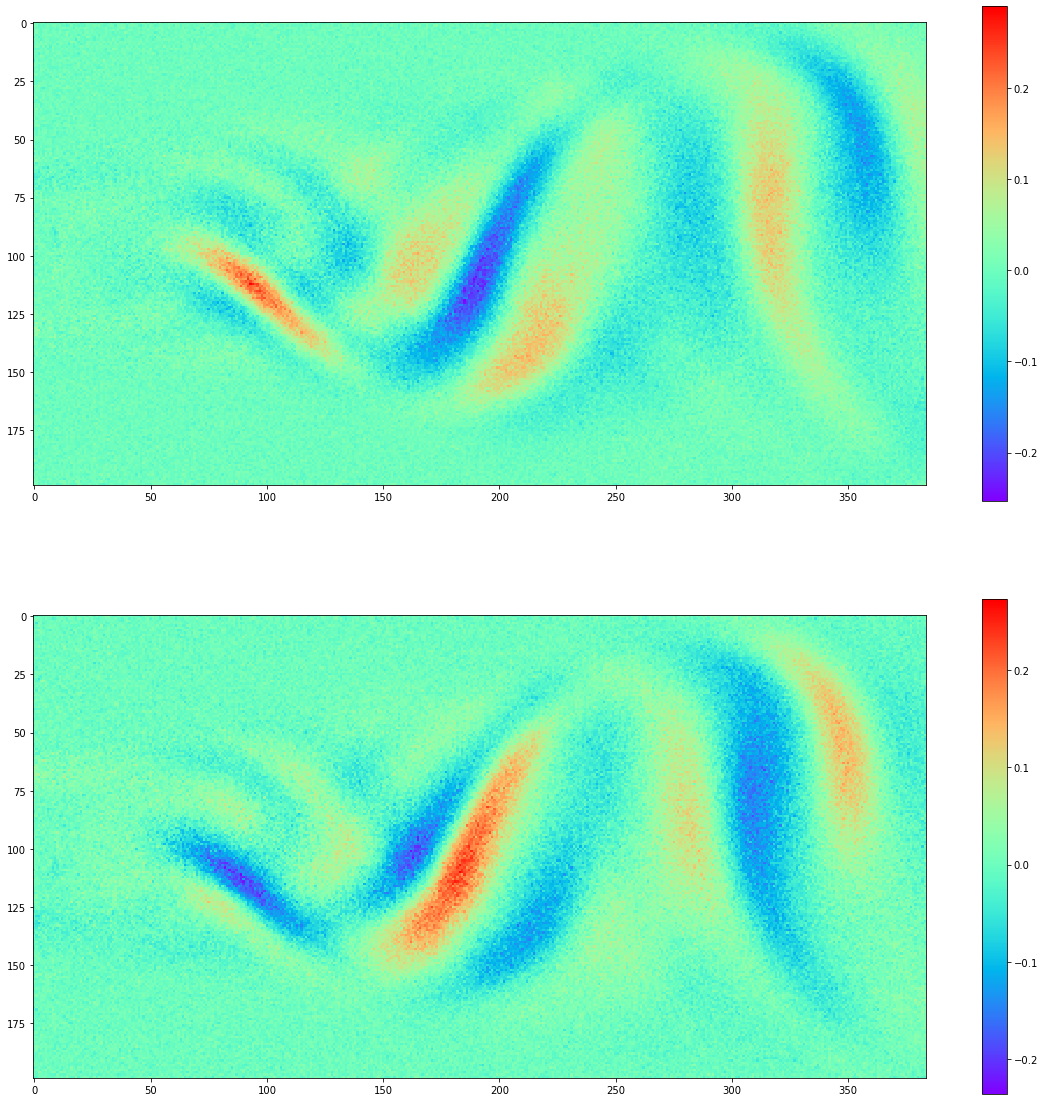

In [45]:
figure(figsize=(20,20))
subplot(211)
imshow(xin[1].reshape((384,199)).T - xout[1].reshape((384,199)).T,cmap='rainbow')
colorbar();
subplot(212)
imshow(xin[1].reshape((384,199)).T - xp[0].reshape((384,199)).T,cmap='rainbow')
colorbar();

In [48]:
lambdas = sess.run(eigv)

In [49]:
lambdas

array([0.96597576, 1.0361717 , 0.97489643, 0.97719306, 1.0359648 ,
       1.019476  , 0.97151965, 0.9694601 , 0.96802914, 1.0421258 ],
      dtype=float32)